In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense,Flatten, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import json
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import os
from IPython.display import clear_output

In [ ]:

for i in range (1,2):
    UsedSample=(i)*0.9
    Iteration=100
    lr=0.00001
    # Define ModelCheckpoint to save best model weights
    #keras=f"Model{i}_Ver2.keras"
    #if os.path.exists(keras):
        #os.remove(keras)
    checkpoint = ModelCheckpoint(
        f"Model{i}_Ver2-1.keras", #Save model
        monitor="val_mse", # Monitor validation MSE
        save_best_only=True, # Only save if validation MSE improves
        mode="min",
        verbose=0
    )

    class PrintMSECallback(Callback):
        def __init__(self, interval=1000):
            self.interval = interval

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.interval == 0:  # Print every `interval` epochs
                mse = logs.get("loss")  # MSE is tracked as "loss" in model.fit()
                print(f"Epoch {epoch+1}: MSE = {mse:.10f}")


    early_stopping = EarlyStopping(
        monitor="mse",       # Monitor validation MSE
        patience=500,           # Stop if no improvement for num epochs
        verbose=0,               # Print when stopping
        mode="min",
        restore_best_weights=True # Restore model weights from best epoch
    )



    with open("nodexy.txt","r") as file:
        NodeOriginal = json.load(file)
    NodeOriginal=np.array(NodeOriginal)
    

    with open("thickness.txt","r") as file:
        element_features = json.load(file)

    energy=np.loadtxt("energy_absorbed.txt")

   
    
    element_features=np.array(element_features)
    print(f"Element total amount{(element_features).shape}")
    energy=np.array(energy).reshape(-1,1)
    
    # Initialize separate scalers
    element_scaler = MinMaxScaler()
    energy_scaler = MinMaxScaler()

    # Extract each feature dimension separately
    NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
    NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
    NodeOriginal_z = NodeOriginal[:, :, 2]  # Extract all z-coordinates
    _, EdgeNodes = np.where((NodeOriginal_x==0) |(NodeOriginal_x==30)| (NodeOriginal_y== 0)|(NodeOriginal_y==30))
    EdheNodes = np.unique(EdgeNodes[1])
    print(EdgeNodes)
    mask=np.ones(25, dtype=bool)
    mask[EdgeNodes] = False
    node_features=NodeOriginal[:, mask,:]
    print(f"Node total amount{(node_features).shape}")
    node_features_x = node_features[:, :, 0]  # Extract all x-coordinates
    node_features_y = node_features[:, :, 1]  # Extract all y-coordinates
    node_features_z = node_features[:, :, 2]  # Extract all z-coordinates
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_z = MinMaxScaler()

    node_features_x = scaler_x.fit_transform(node_features_x)  # Scale X
    node_features_y = scaler_y.fit_transform(node_features_y)  # Scale Y
    node_features_z = scaler_z.fit_transform(node_features_z)  # Scale Z


    # Stack them back together
    node_features = np.stack([node_features_x, node_features_y], axis=-1)  # Back to (N, 25, 3)
    element_features = element_scaler.fit_transform(element_features)
    energy = energy_scaler.fit_transform(energy)
    # Split into training and testing sets
    X_other_nodes,X_train_nodes,X_other_elements, X_train_elements,energy_test, energy_train = train_test_split(
        node_features, element_features, energy, test_size=int(UsedSample*len(energy)), random_state=42)
    print(f"train samples:{(energy_train).shape}")

    X_NN, X_test_nodes,XEN, X_test_elements,y_not_use, y_test=train_test_split(
        X_other_nodes,X_other_elements,energy_test,test_size=100)
    print(f"test samples:{(y_test).shape}", f"not used samples:{(y_not_use).shape}")

    # Define multi-branch ANN
    node_input = Input(shape=(13,2), name="Node_Input")
    node_branch = Dense(32,activation="swish")(node_input)
    node_branch = Dropout(0.4)(node_branch)
    node_branch = Dense(16, activation="swish")(node_branch)
    node_branch = Dropout(0.2)(node_branch)
    node_branch = Dense(8, activation="swish")(node_branch)
    node_branch = Flatten()(node_branch)

    element_input = Input(shape=(36,), name="Element_Input")
    element_branch = Dense(32,activation="swish")(element_input)
    #element_branch = Dropout(0.4)(element_branch)
    element_branch = Dense(16, activation="swish")(element_branch)
    #element_branch = Dropout(0.2)(element_branch)
    element_branch = Dense(8, activation="swish")(element_branch)

    # Concatenate branches
    merged = Concatenate()([node_branch, element_branch])
    merged = Dense(16, activation="elu")(merged)
    #merged = Dense(16, activation="elu")(merged)
    merged = Dense(8, activation="elu")(merged)
    #merged = Dense(4, activation="elu")(merged)
    #merged = Dense(2, activation="elu")(merged) 
    output = Dense(1, activation="linear", name="Prediction_Output")(node_branch)

    # Create model
    model = Model(inputs=[node_input,element_input], outputs=output)
    #model=load_model(f"Model{i}_Ver2.keras")
    #model.summary()
    reduce_lr = ReduceLROnPlateau(monitor="val_mse", factor=0.8, patience=300, min_lr=1e-6, verbose=0) 
    optimizer = AdamW(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae","mse"])

    # Train model
    mse_callback = PrintMSECallback(interval=1000)
    print(X_train_nodes.shape)
    print(X_train_elements.shape)
    print(energy_train.shape)
    history = model.fit([X_train_nodes,X_train_elements], 
                        energy_train, epochs=Iteration, 
                        batch_size=1024, 
                        validation_split=0.1,
                        callbacks=[mse_callback,checkpoint,reduce_lr,early_stopping],
                        verbose=0)
    #print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
    clear_output(wait=True)

Element total amount(1308, 36)
[ 0  2  8 ... 22 23 24]
Node total amount(1308, 13, 3)
train samples:(1177, 1)
test samples:(100, 1) not used samples:(31, 1)
(1177, 13, 2)
(1177, 36)
(1177, 1)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


[[[0.44589569 0.01809098]
  [0.53273698 0.76354356]
  [0.43010004 0.47877625]
  ...
  [0.9632642  0.53828569]
  [0.12733258 0.30792488]
  [0.1945851  0.51998014]]

 [[0.20313049 0.24569172]
  [0.31520444 0.82680067]
  [0.0647334  0.87404997]
  ...
  [0.50171828 0.82941966]
  [0.4985002  0.14725584]
  [0.00243476 0.91581796]]

 [[0.01780165 0.19614971]
  [0.09961095 0.66028451]
  [0.1101166  0.98803391]
  ...
  [0.02600782 0.88138535]
  [0.3322689  0.21491331]
  [0.40288276 0.25473492]]

 ...

 [[0.81082508 0.09751958]
  [0.43578031 0.89823362]
  [0.55962132 0.90638737]
  ...
  [0.65819689 0.5869152 ]
  [0.62243996 0.78116917]
  [0.2614178  0.09769935]]

 [[0.14679565 0.47158415]
  [0.80652262 0.73436795]
  [0.00563159 0.24885138]
  ...
  [0.10381663 0.32422841]
  [0.16506224 0.87970916]
  [0.63501551 0.76601401]]

 [[0.40896613 0.08054275]
  [0.56390403 0.81819494]
  [0.71273301 0.70351651]
  ...
  [0.15965608 0.53293462]
  [0.97941512 0.28923797]
  [0.03440983 0.52629189]]]


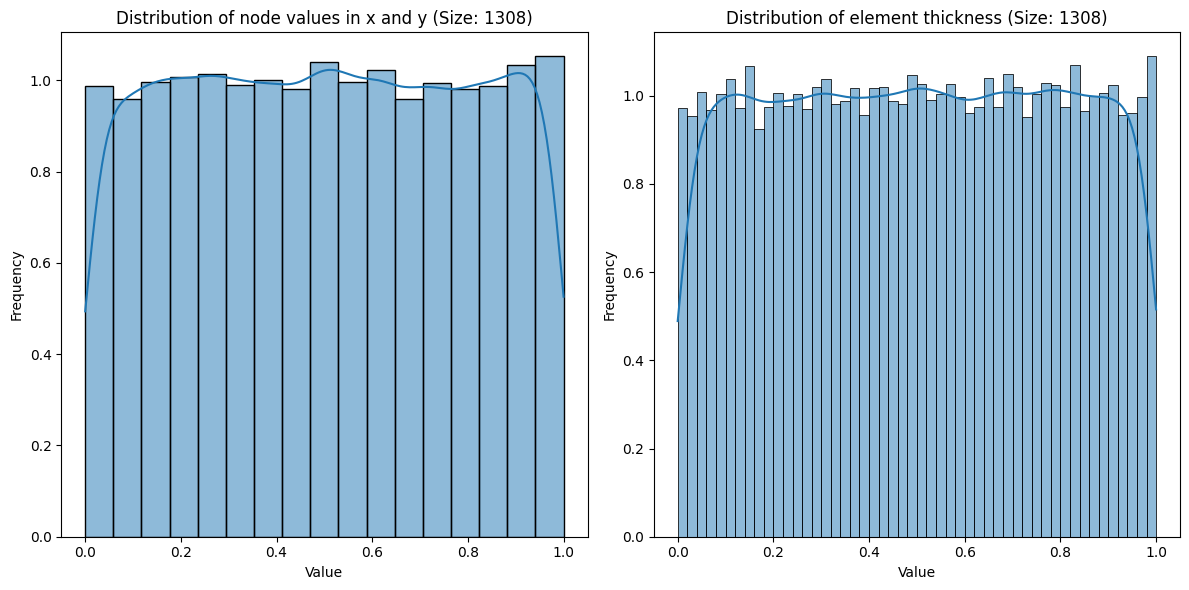

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
# Generate synthetic data
data1 = node_features.reshape(-1,2)  # Flattening along the first two axes
print(node_features)
#print(node_features_x)
data2 = X_train_elements.reshape(-1)  # Flattening along the first axis
#print(X_train_elements.shape)
# Plot distributions
plt.figure(figsize=(12, 6))

# Distribution of first dataset
plt.subplot(1, 2, 1)
sns.histplot(data1.flatten(), bins=17, kde=True,stat="density")
plt.title("Distribution of node values in x and y (Size: 1308)")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Distribution of second dataset
plt.subplot(1, 2, 2)
sns.histplot(data2, bins=50, kde=True,stat="density")
plt.title("Distribution of element thickness (Size: 1308)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


 Loaded Model1_Ver2.keras successfully!
train samples:(1177, 1)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1177, 1)


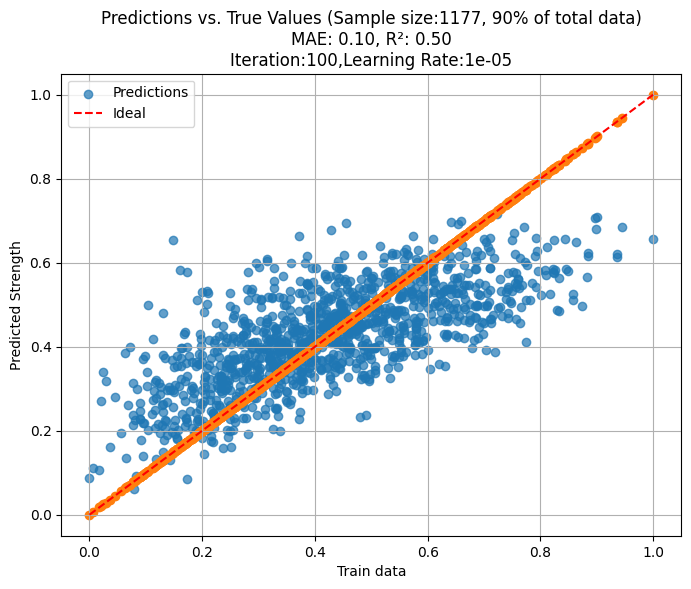

In [74]:
# Plot predictions vs. true values
i=1
try:
    model = load_model(f"Model{i}_Ver2.keras")
    print(f" Loaded Model{i}_Ver2.keras successfully!")
except:
    print(" No saved model found! Training from scratch.")
X_other_nodes,X_train_nodes,X_other_elements, X_train_elements,energy_test, energy_train = train_test_split(
        node_features, element_features, energy, test_size=int(0.9*len(energy)), random_state=42)
print(f"train samples:{(energy_train).shape}")

y_pred = model.predict([X_train_nodes,X_train_elements])
print(y_pred.shape)
mae = mean_absolute_error(energy_train, y_pred)
r2 = r2_score(energy_train, y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(energy_train, y_pred, alpha=0.7, label="Predictions")
plt.scatter(energy_train,energy_train)
plt.plot([min(energy_train), max(energy_train)], [min(energy_train), max(energy_train)], color="red", linestyle="--", label="Ideal")
plt.xlabel("Train data")
plt.ylabel("Predicted Strength")
plt.title(f"Predictions vs. True Values (Sample size:{int(i*0.9*len(energy))}, {round(i*0.9*100)}% of total data)\nMAE: {mae:.2f}, R²: {r2:.2f}\nIteration:{Iteration},Learning Rate:{lr}")
plt.legend()
plt.grid(True)
plt.show()

 Loaded saved model successfully!
test samples:(100, 1) not used samples:(31, 1)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1123 - mae: 0.1123 - mse: 0.0210  
Validation loss: [0.1105133444070816, 0.1105133444070816, 0.020392971113324165]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


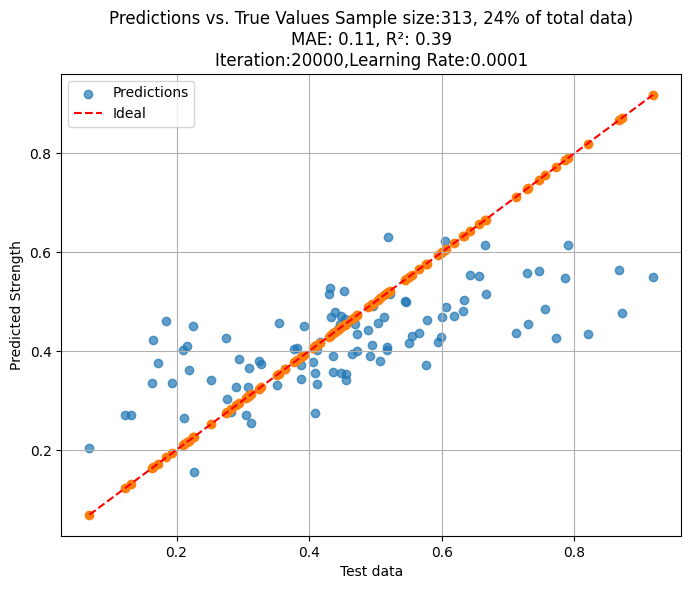

In [21]:
# Plot predictions vs. true values
try:
    model = load_model(f"Model{i}_Ver2.keras")
    print(" Loaded saved model successfully!")
except:
    print(" No saved model found! Training from scratch.")
    
X_NN, X_test_nodes,XEN, X_test_elements,y_not_use, y_test=train_test_split(
        X_other_nodes,X_other_elements,energy_test,test_size=100)
print(f"test samples:{(y_test).shape}", f"not used samples:{(y_not_use).shape}")

val_loss_before = model.evaluate([X_test_nodes, X_test_elements], y_test)
print(f"Validation loss: {val_loss_before}")
y_pred = model.predict([X_test_nodes, X_test_elements]).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.scatter(y_test,y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal")
plt.xlabel("Test data")
plt.ylabel("Predicted Strength")
plt.title(f"Predictions vs. True Values Sample size:{int(i*0.24*len(energy))}, {round(i*0.24*100)}% of total data)\nMAE: {mae:.2f}, R²: {r2:.2f}\nIteration:{Iteration},Learning Rate:{lr}")
plt.legend()
plt.grid(True)
plt.show()